In [1]:
import ray
GPU_UTILIZATION = 0.0
ray.init(num_gpus=GPU_UTILIZATION)

2023-11-21 23:46:15,757	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-11-21 23:46:17,630	INFO worker.py:1664 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.13
Ray version:,2.8.0
Dashboard:,http://127.0.0.1:8265


In [2]:
import torch
import torch.nn as nn

from ray.rllib.models import ModelCatalog
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2

class CustomTorchModel(TorchModelV2):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        super(CustomTorchModel, self).__init__(
            obs_space, action_space, num_outputs, model_config, name
        )
        self.l1 = nn.Linear(obs_space.shape[0], 2)
        self.l2 = nn.Linear(2, 1)
    def forward(self, input_dict, state, seq_lens):
        x = self.l1(input_dict["obs"])
        self.value_out = self.l2(x)
        return x, state
    def value_function(self):
        return self.value_out

ModelCatalog.register_custom_model("my_torch_model", CustomTorchModel)

2023-11-21 23:46:20,591	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [6]:
from ray.rllib.algorithms.ppo import PPOConfig

config = PPOConfig().training(model = {"custom_model":"my_torch_model"}, gamma=0.9, lr=0.0001, train_batch_size=512, sgd_minibatch_size=256)
config = config.resources(num_gpus=GPU_UTILIZATION, num_learner_workers=1, num_gpus_per_worker=0, num_gpus_per_learner_worker=GPU_UTILIZATION)
config = config.rollouts(num_rollout_workers=4,create_env_on_local_worker=True)
config = config.framework("torch")

algo = config.build(env="CartPole-v1")  

ValueError: Cannot use `custom_model` option with RLModule API. `custom_model` is part of the ModelV2 API and Policy API, which are not compatible with the RLModule API. You can either deactivate the RLModule API by setting `config.rl_module( _enable_rl_module_api=False)` and `config.training(_enable_learner_api=False)` ,or use the RLModule API and implement your custom model as an RLModule.

In [6]:
from time import time 
init_eval = algo.evaluate()

t1 = time()
for i in range(32):
    print(i,end='\r')
    algo.train()

print(time() - t1)
post_eval = algo.evaluate()

23.198487758636475


In [7]:
print('Mean reward per episode')
print('Before training: ',init_eval['evaluation']['episode_reward_mean'])
print('After training: ',post_eval['evaluation']['episode_reward_mean'])

init:  21.593220338983052
post:  208.66666666666666


In [1]:
import gymnasium as gym 
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [3]:
env = gym.make('CartPole-v1', render_mode="rgb_array")
model = algo.get_policy().model

In [14]:
env.observation_space.shape[0]

4

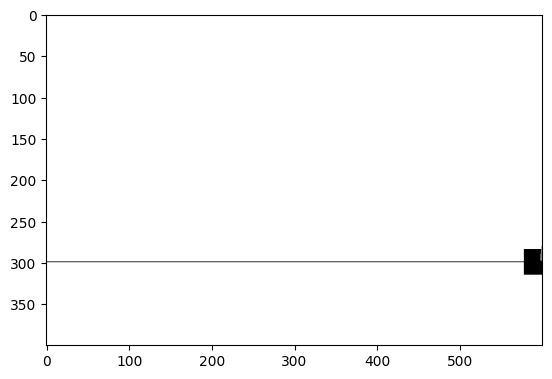

Episode finished after 140 steps


In [55]:
initial_state = env.reset()

for step in range(num_steps):
    with torch.no_grad():
        action = model({'obs': torch.Tensor(next_state.reshape([1,4]))})['action_dist_inputs'].argmax().item()

    next_state, reward, done = env.step(action)[:3]

    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()

    print(step, end='\r')
    
    if done:
        print(f"Episode finished after {step+1} steps")
        break